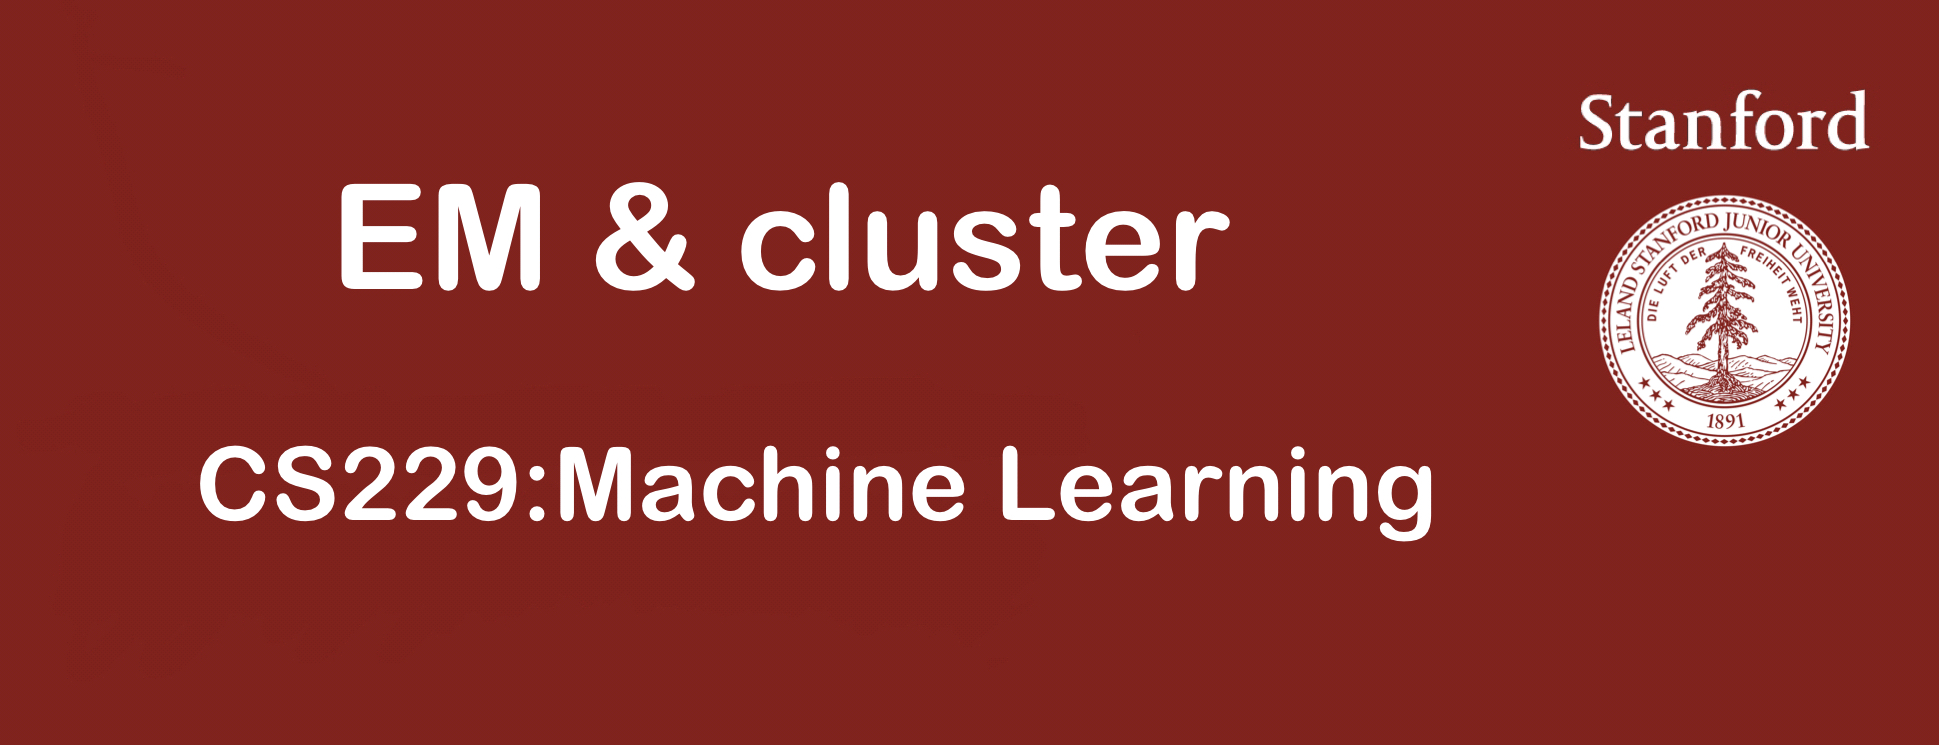

## 1. The k-means clustering algorithm

聚类问题是一种 **「无监督学习(unsupervised learning)」** ，给定训练集 $\{x^{(1)},...,x^{(m)}\}$，我们希望将其聚合成几个特定的类。k-means 聚类算法的流程如下：

1. 随机初始化 **「聚类中心(cluster centroids)」** $\mu_1,\mu_2,...,\mu_k \in\mathbb R^n$

2. 重复以下步骤直至收敛： 对于每个 $i$（训练集大小），令 $c^{(i)}:=\underset{j}{\text{argmin}}{\parallel x^{(i)}-\mu_j \parallel}^2$ ,对于每个 $j$（聚类数量），令

$$\mu^{(j)}:=\frac{\sum_{i=1}^m 1 \{ c^{(i)}=j\}x^{(i)}}{\sum_{i=1}^m 1\{ c^{(i)}=j\}}$$

该算法的思想为：先将每个训练样本 $x^{(i)}$ 分配到距离其最近的中心 $\mu_j$，再将每个聚类中心移动到第一步中分配到该中心的样本的均值。

下图可视化了 k-means 算法的运行流程：

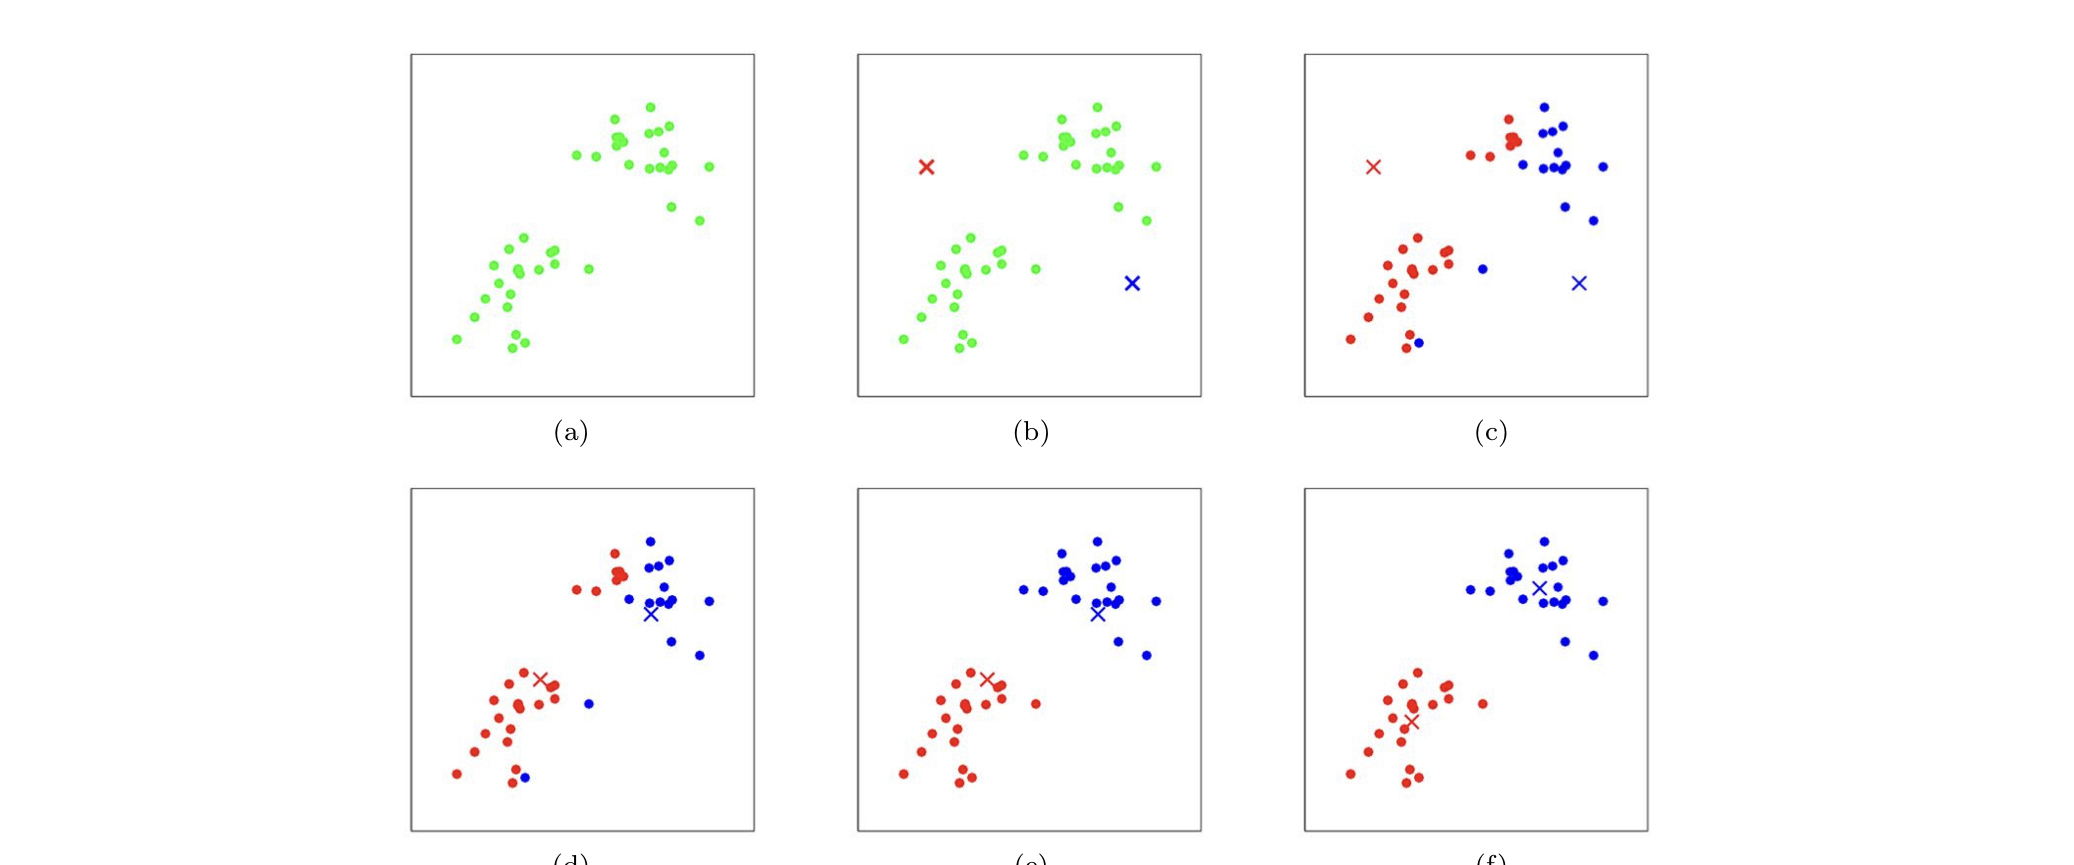

为了证明 k-means 算法能否保证收敛，我们定义 **「失真函数(distortion function)」** 为：

$$J(c,\mu)=\sum_{i=1}^m {\parallel x^{(i)}-\mu_{c^{(i)}}\parallel}^2$$

可以发现 k-means 本质上就是对失真函数进行坐标上升法优化：其内层循环首先保持 $\mu$ 不变关于 $c$ 最小化 $J$，然后保持 $c$ 不变关于 $\mu$ 最小化 $J$。因此，$J$ 一定会持续下降，最终达到收敛。一般 $c$ 和 $\mu$ 也会收敛，但理论上存在同时出现多种聚类组合的可能性，使得失真函数的值一样。

失真函数是一个非凸函数，这意味着坐标上升并不能保证其收敛至全局最优，存在收敛到局部最优的可能性。一般情况下这不会发生，可以通过多次运行 k-means 算法，选择最优解来解决这个问题。

## 2. 混合高斯分布(Mixtures of Gaussians)

混合高斯分布可以用于软聚类问题，即输出一个样本属于各个类的概率。我们可以将数据的类别看作一个隐含随机变量 [公式]，并给出如下假设：

1. $z$ 服从多项式分布 $z^{(i)} \sim \text{Multinomial}(\phi)$

2. 给定不同的 $z$ ，$x$ 服从不同的高斯分布 $x^{(i)}|x^{(i)}=j \sim \mathcal{N}(\mu_i,\Sigma_j)$

使用极大似然法求解该优化问题，可以得到如下的似然函数：

$$\ell(\phi,\mu,\Sigma)=\sum_{i=1}^m \text{log}p(x^{(i)};\phi,\mu,\Sigma)=\sum_{i=1}^m \text{log} \sum_{z^{(i)}=1}^k p(x^{(i)}|z^{(i)};\mu,\Sigma)p(z^{(i)};\phi)$$

该问题无法求出闭合解。如果 $z^{(i)}$ 已知，即我们知道每个样本来自于哪个高斯分布，那么极大似然估计的求解是容易的，似然函数如下：

$$\ell(\phi,\mu,\Sigma)=\sum_{i=1}^m(\text{log}p(x^{(i)}|z^{(i)};\mu,\Sigma)+\text{log}p(z^{(i)};\phi))$$

求解的结果是：

$$\phi_j=\frac{1}{m}\sum_{i=1}^m 1 \{z^{(i)}=j\}$$

$$\mu_j=\frac{\sum_{i=1}^m 1 \{z^{(i)}=j\}x^{(i)}}{\sum_{i=1}^m 1 \{ z^{(i)}=j\}}$$

$$\Sigma_j=\frac{\sum_{i=1}^m 1 \{z^{(i)}=j\}(x^{(i)}-\mu_j)(x^{(i)}-\mu_j)^T}{\sum_{i=1}^m 1 \{ z^{(i)}=j\}}$$

该结果与之前的高斯判别分析的结论类似（GDA 的协方差矩阵必须相同）。

## 3. EM 算法初步

实际上，我们并不知道 $z^{(i)}$ 的值。我们可以通过 EM 算法进行迭代估计出 $z^{(i)}$ 从而得到参数，其基本思想如下：

重复以下步骤直至收敛：

1. 「E-step」对于每个 $i,j$，令：

$$w_j^{(i)}:=p(z^{(i)}=j|x^{(i)};\phi,\mu,\Sigma)$$

2. 「M-step」更新参数：

$$\phi_j=\frac{1}{m}\sum_{i=1}^m w_j^{(i)}$$

$$\mu_j=\frac{\sum_{i=1}^m w_j^{(i)}x^{(i)}}{\sum_{i=1}^m w_j^{(i)}}$$

$$\Sigma_j=\frac{\sum_{i=1}^m w_j^{(i)}(x^{(i)}-\mu_j)(x^{(i)}-\mu_j)^T}{\sum_{i=1}^m w_j^{(i)}}$$

关于 EM 算法的几点解释：

在 「E-step」 中，给定 $x^{(i)}$，我们使用当前的参数值来计算 $z^{(i)}$ 的后验概率，即

$$p(z^{(i)}=j|x^{(i)};\phi,\mu,\Sigma)=\frac{p(x^{(i)}|z^{(i)}=j;\mu,\Sigma)p(z^{(i)}=j;\phi)}{\sum_{i=1}^k p(x^{(i)}|z^{(i)}=l;\mu,\Sigma)p(z^{(i)}=l;\phi)}$$

该概率代表我们对 $z^{(i)}$ 值的软猜测（即以概率值代替具体的值）。

在 「M-step」 中，参数的更新公式与之前已知 $z^{(i)}$ 的公式相比，只是把指示函数替换为了概率。

与 K-means 算法相比，EM 算法输出的是样本属于各个类的概率，这是一种软聚类。与 K-means 相似，EM 算法容易陷入局部最优，因此多次尝试不同的初始参数可能是一个好主意。下两节将给出 EM 算法的一般形式，并证明其收敛性。

## 4. Jensen's inequality

本节将介绍 Jensen 不等式，其在 EM 算法中有着重要的作用。

### 4.1 函数的凹凸性

在介绍 Jensen 不等式之前，先简单回顾一下函数的凹凸性。对于一个实数域的函数 $f$，其为凸函数的条件为 $f">\geq 0$。如果输入为向量形式，则该条件可推广为其 Hessian 矩阵半正定（$H \geq 0$）。

如果 $f"(x) >0 (H >0)$，则函数 **「严格」** 凸。凹函数的判定条件与凸函数完全相反。

### 4.2 定理

令 $f$ 是一个凸函数，$X$ 是一个随机变量，则：

$$E[f(X)]\geq f(EX)$$

如果 $f$ 严格凸，那么当且仅当 $X=E[X]$ 时等号成立（即 $X$ 为常量）。可以通过下图对该不等式有一个直观的理解：

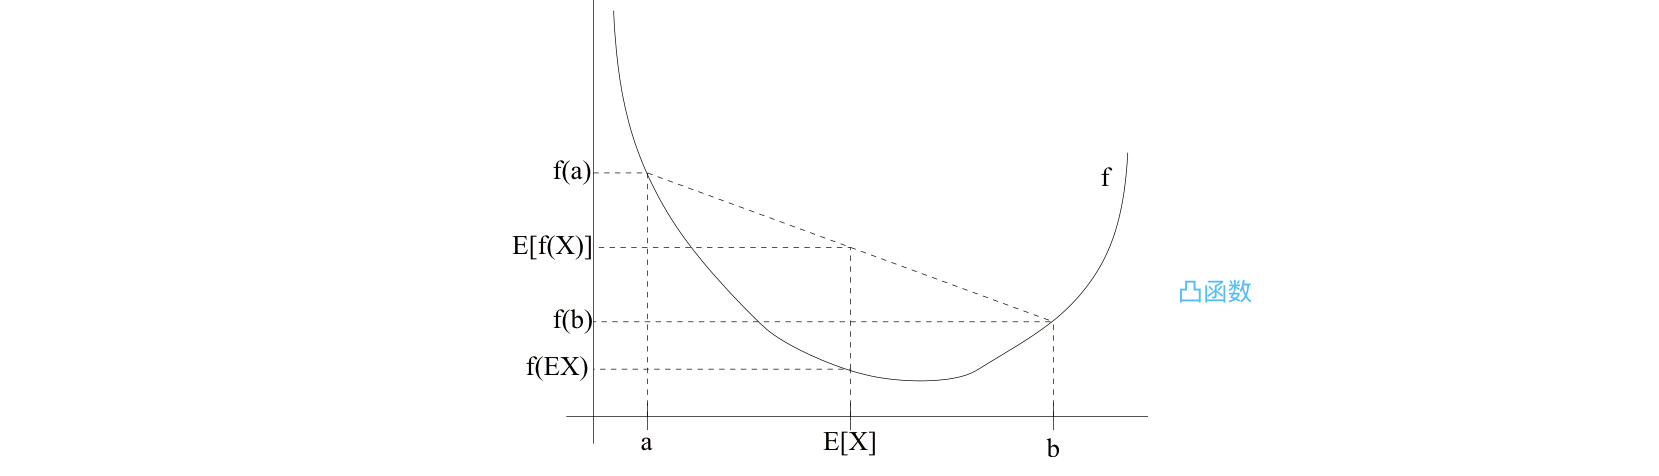

当 $f$ 为凹函数时，不等式方向对调，仍然成立。

## 5. EM 算法

### 5.1 算法的导出

假定我们有一个包含 m 个独立样本的训练集，我们希望去拟合一个概率模型 $p(x,z)$，其对数似然函数为：

$$\ell(\theta)=\sum_{i=1}^m \text{log}p(x;\theta)=\sum_{i=1}^m\text{log}\sum_z p(x,z;\theta)$$

这里假定 $z$ 是 **「离散」** 变量（连续变量需要使用积分）。

直接最大化 $\ell$ 是难以求解的。EM 算法的思想是先构建一个 $\ell$ 的下界（E-step），然后去优化这个下界（M-step），达到间接最大化 $\ell$ 的目的。

对于每个 $i$，设 $Q_i$ 是 $z$ 的某种概率分布（$\sum_z Q_i(z)=1,Q_i(z)\geq 0$）。根据期望的定义以及 Jensen 不等式，我们有：

$$\sum_i\text{log}p(x^{(i)};\theta)=\sum_i\text{log}\sum_{z^{(i)}}p(x^{(i)},z^{(i)};\theta)\tag{1}$$

$$\qquad \qquad \qquad \qquad \quad=\sum_i\text{log}\sum_{z^{(i)}}Q_i(z^{(i)})\frac{p(x^{(i)},z^{(i)};\theta)}{Q_i(z^{(i)})}\tag{2}$$

$$\qquad \qquad \qquad \qquad \quad\geq \sum_i\sum_{z^{(i)}}Q_i(z^{(i)})\text{log}\frac{p(x^{(i)},z^{(i)};\theta)}{Q_i(z^{(i)})}\tag{3}$$

$\frac{p(x^{(i)},z^{(i)};\theta)}{Q_i(z^{(i)})}$ 可以看做 $z^{(i)}$ 的随机变量，其概率分布为 $Q_i$，期望可以通过$\sum_{z^{(i)}}Q_i(z^{(i)})\text{log}\frac{p(x^{(i)},z^{(i)};\theta)}{Q_i(z^{(i)})}$ 得到。$f(x)=\text{log}x$ 是一个凹函数，应用 Jensen 不等式时注意方向对调。

为了执行 EM 算法，我们需要选择合适的 $Q_i$ 以保证在当前的参数设置下取到下界，即目前的 $\theta$ 值能够使得 (3) 式的等号成立。之前的定理表明等号成立的条件是随机变量为 **「常数」**：

$$\frac{p(x^{(i)},z^{(i)};\theta)}{Q_i(z^{(i)})}=c$$

因此只要 $Q_i(z^{(i)})$ 和 $p(x^{(i)},z^{(i)};\theta)$ 成比例即可：

$$Q_i(z^{(i)}) \propto p(x^{(i)},z^{(i)};\theta)$$

实际上，因为 $\sum_z Q_i(z^{(i)})=1$，将其代入上述公式，可以得到：

$$\sum_z Q_i(z^{(i)})=\frac{\sum_z p(x^{(i)},z^{(i)};\theta)}{c}=1$$

因此 $c=\sum_z p(x^{(i)},z^{(i)};\theta)$，从而有：

$$Q_i(z^{(i)})=\frac{p(x^{(i)},z^{(i)};\theta)}{\sum_z p(x^{(i)},z^{(i)};\theta)}=\frac{p(x^{(i)},z^{(i)};\theta)}{p(x^{(i)};\theta)}=p(z^{(i)}|x^{(i)};\theta)$$

根据上述推导，我们只需要将 $Q_i$ 设置为给定 $x^{(i)}$ 时 $z^{(i)}$ 的后验分布即可（以 $\theta$ 为参数）。

综上所述，EM 算法的具体步骤为：

* **「E-step」**：对于每个 $i$，令 $Q_i(z^{(i)}):=p(z^{(i)}|x^{(i)};\theta)$

* **「M-step」**：更新参数 $\theta:=\underset{\theta}{\text{argmax}}\sum_i \sum_z^{(i)} Q_i(z^{(i)})\text{log}\frac{p(x^{(i)},z^{(i)};\theta)}{Q_i(z^{(i)})}$

重复以上两个步骤直至收敛。

### 5.2 收敛性证明

下面证明该算法的收敛性。假定 $\theta^{(t)}$ 和 $\theta^{(t+1)}$ 来自于 EM 算法的两次成功的迭代，那么通过证明 $\ell(\theta^{(t)})\leq \ell(\theta^{(t+1)})$，就可以表明 EM 算法是单调收敛的（对数似然函数单调递增）。

当参数为 $\theta^{(t)}$ 时，根据算法步骤，我们令 $Q_i^{(t)}(z^{(i)}):=p(z^{(i)}|x^{(i)};\theta^{(t)})$，这一选择保证了等号成立，即：

$$\ell(\theta^{(t)})=\sum_i\sum_{z^{(i)}}Q_i^{(t)}(z^{(i)})\text{log}\frac{p(x^{(i)},z^{(i)};\theta^{(t)})}{Q_i^{(t)}(z^{(i)})}$$

而参数 $\theta^{(t+1)}$ 是通过最大化上式的右边部分得出的（更新 $\theta$），因此有：

$$\ell(\theta^{(t=1)})\geq \sum_i\sum_{z^{(i)}}Q_i^{(t)}(z^{(i)})\text{log}\frac{p(x^{(i)},z^{(i)};\theta^{(t+1)})}{Q_i^{(t)}(z^{(i)})}\tag{4}$$

$$\geq \sum_i\sum_{z^{(i)}}Q_i^{(t)}(z^{(i)})\text{log}\frac{p(x^{(i)},z^{(i)};\theta^{(t)})}{Q_i^{(t)}(z^{(i)})}\tag{5}$$

$$=\ell(\theta^{(t)})\tag{6}$$

综上所述，EM 算法可以保证似然函数的 **「单调收敛」**。一个可取的收敛条件是 $\ell(\theta)$ 的增长速度小于某个临界值。

### 5.3 坐标上升法

如果我们定义：

$$J(Q,\theta)=\sum_i \sum_z^{(i)} Q_i(z^{(i)})\text{log}\frac{p(x^{(i)},z^{(i)};\theta)}{Q_i(z^{(i)})}$$

从之前的推导可以知道 $\ell(\theta)\geq J(Q,\theta)$。

那么 EM 算法可以看做是对 $J$ 的坐标上升法：

* 在 E-step 中，关于 $Q$ 最大化 $J$（使等号成立）

* 在 M-step 中，关于 $\theta$ 最大化 $J$

## 6 混合高斯模型复盘

下面将使用 EM 算法的一般形式来对之前混合高斯模型中的公式进行推导，由于篇幅所限，这里只给出 $\phi$ 和 $\mu_j$ 的推导过程。

之前我们得出的参数更新公式如下：

$$\phi_j=\frac{1}{m}\sum_{i=1}^m w_j^{(i)}$$

$$\mu_j=\frac{\sum_{i=1}^m w_j^{(i)}x^{(i)}}{\sum_{i=1}^m w_j^{(i)}}$$

$$\Sigma_j=\frac{\sum_{i=1}^m w_j^{(i)}(x^{(i)}-\mu_j)(x^{(i)}-\mu_j)^T}{\sum_{i=1}^m w_j^{(i)}}$$

根据 E-step 的定义，我们可以得到：

$$w_j^{(i)}=Q_i(z^{(i)}=j)=P(z^{(i)}=j|x^{(i)};\phi,\mu,\Sigma)$$

在 M-step 中，我们需要通过上述三个参数去最大化下式：

$$\sum_{i=1}^m \sum_{z^{(i)}}Q_i(z^{(i)})\text{log}\frac{p(x^{(i)},z^{(i)};\phi,\mu,\Sigma)}{Q_i(z^{(i)})}\qquad \qquad \qquad \qquad$$

$$=\sum_{i=1}^m \sum_{j=1}^k Q_i(z^{(i)}=j)\text{log}\frac{p(x^{(i)}|z^{(i)}=j;\mu,\Sigma)p(z^{(i)}=j;\phi)}{Q_i(z^{(i)}=j)}\qquad\qquad$$

$$=\sum_{i=1}^m \sum_{j=1}^k w_j^{(i)}\text{log}\frac{\frac{1}{(2\pi)^{n/2}|\Sigma_j|^{1/2}}\text{exp}(-\frac{1}{2}(x^{(i)}-\mu_j)^T\Sigma_j^{-1}(x^{(i)}-\mu_j))\cdot \phi_j}{w_j^{(i)}}\quad$$

我们首先关于 $\mu_j$ 去进行最大化，求导可得：

$$\triangledown_{\mu_j} \sum_{i=1}^m \sum_{j=1}^k w_j^{(i)}\text{log}\frac{\frac{1}{(2\pi)^{n/2}|\Sigma_j|^{1/2}}\text{exp}(-\frac{1}{2}(x^{(i)}-\mu_j)^T\Sigma_j^{-1}(x^{(i)}-\mu_j))\cdot \phi_j}{w_j^{(i)}}$$

$$\quad=-\triangledown_{\mu_j} \sum_{i=1}^m \sum_{j=1}^k w_j^{(i)}\frac{1}{2}(x^{(i)}-\mu_j)^T\Sigma_j^{-1}(x^{(i)}-\mu_j)$$

$$=\frac{1}{2}\sum_{i=1}^m w_j^{(i)}\triangledown_{\mu_j}2\mu_j^T \Sigma_j^{-1}x^{(i)}-\mu_j^T\Sigma_j^{-1}\mu_j\qquad$$

$$=\sum_{i=1}^m w_j^{(i)}(\Sigma_j^{-1}x^{(i)}-\Sigma_j^{-1}\mu_j)\qquad \quad \qquad \quad$$

上述推导首先去除了不相关的项，然后去除了求和符号（只求当前的 $j$ 的导数），最后合并同类项得到结果。将上式设为 0 求解 $\mu_j$，可得：

$$\mu_j=\frac{\sum_{i=1}^m w_j^{(i)}x^{(i)}}{\sum_{i=1}^m w_j^{(i)}}$$

下面关于 $\phi_j$ 去进行最大化，将与 $\phi_j$ 相关的部分提取出来，可以得到需要最大化的项为：

$$\sum_{i=1}^m \sum_{j=1}^k w_j^{(i)}log\phi_j$$

这里我们还有一个额外的约束条件：$\sum_{j=1}^k \phi_j=1$

因此，我们需要构建拉格朗日算子：

$$\mathcal{L}(\phi)=\sum_{i=1}^m\sum_{j=1}^k w_j^{(i)}\text{log}\phi_j + \beta(\sum_{j=1}^k \phi-1)$$

其中 $\beta$ 是拉格朗日乘数，对上式求导可得：

$$\frac{\partial}{\partial \phi_j}\mathcal{L}(\phi)=\sum_{i=1}^m\frac{w_j^{(i)}}{\phi_j}+\beta$$

将其设为 0，可得：

$$\phi_j=\frac{\sum_{i=1}^m w_j^{(i)}}{-\beta}$$

由于 $\sum_{j=1}^k \phi_j=1$，因此 $-\beta=\sum_{i=1}^m \sum_{j=1}^k w_j^{(i)}=\sum_{i=1}^m 1 = m$，所以：

$$\phi_j=\frac{1}{m}\sum_{i=1}^m w_j^{(i)}$$